In [1]:
import numpy as np
import keras
import tensorflow
from keras import layers
from keras.models import Sequential
from keras import callbacks
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot
import os

logdir = os.path.join("callbacks")

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# load dataset
dataset = pd.read_csv('CER_Resident_Power_556.csv', header=0, index_col=0)
dataset = dataset.loc[:, ['Power', 'holidays', 'Hour', 'Days', 'Month', 'Temperature', 'humiduity', 'Wind_speed']]
print(dataset.head())
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 536 * 48 - 7 * 48 - 1
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

     Power  holidays  Hour  Days  Month  Temperature  humiduity  Wind_speed
0  184.337         0   0.0    14      7         11.8       93.0        14.4
1  162.016         0   0.5    14      7         11.8       91.0        14.4
2  140.663         0   1.0    14      7         11.8       89.0        18.0
3  128.021         0   1.5    14      7         11.6       91.0        18.0
4  117.371         0   2.0    14      7         11.4       93.0        10.8
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.133449        0.0   0.000000   0.433333   0.545455   0.673469   
2   0.102049        0.0   0.021277   0.433333   0.545455   0.673469   
3   0.072012        0.0   0.042553   0.433333   0.545455   0.673469   
4   0.054228        0.0   0.063830   0.433333   0.545455   0.667639   
5   0.039247        0.0   0.085106   0.433333   0.545455   0.661808   

   var7(t-1)  var8(t-1)   var1(t)  
1       0.93   0.166667  0.102049  
2       0.91   0.166667  0.072012  
3       0

In [3]:
def build_model(n_hidden=1, n_neurons=50, learning_rate=1e-1, input_shape=(train_X.shape[1], train_X.shape[2])):
    model = Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(layers.LSTM(n_neurons, return_sequences=True, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mse'])
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs= {
    "n_hidden": np.arange(1, 10).tolist(),
    "n_neurons": np.arange(1, 500).tolist(),
    "learning_rate": [3e-2, 3e-3, 3e-4, 3e-5, 3e-6, 3e-7],
    #"batch_size":np.arange(1, 200).tolist(),
}

checkpoint_cb = keras.callbacks.ModelCheckpoint('load_forecasting_New_best.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=5)
rnd_search_cv.fit(train_X, train_y, epochs=100, validation_split=0.1, shuffle=True, batch_size=64,
                  callbacks=[checkpoint_cb, early_stopping_cb])


print(rnd_search_cv.best_params_)
print('score:', rnd_search_cv.best_score_)

Epoch 1/100
286/286 [==============================] - 24s 52ms/step - loss: 0.2619 - mse: 0.0996 - val_loss: 0.3464 - val_mse: 0.1687
Epoch 2/100
286/286 [==============================] - 13s 47ms/step - loss: 0.2614 - mse: 0.0999 - val_loss: 0.3428 - val_mse: 0.1662
Epoch 3/100
286/286 [==============================] - 14s 50ms/step - loss: 0.2554 - mse: 0.0957 - val_loss: 0.3389 - val_mse: 0.1635
Epoch 4/100
286/286 [==============================] - 14s 48ms/step - loss: 0.2531 - mse: 0.0953 - val_loss: 0.3343 - val_mse: 0.1605
Epoch 5/100
286/286 [==============================] - 14s 47ms/step - loss: 0.2495 - mse: 0.0931 - val_loss: 0.3293 - val_mse: 0.1571
Epoch 6/100
286/286 [==============================] - 14s 47ms/step - loss: 0.2419 - mse: 0.0898 - val_loss: 0.3236 - val_mse: 0.1534
Epoch 7/100
286/286 [==============================] - 14s 48ms/step - loss: 0.2369 - mse: 0.0862 - val_loss: 0.3173 - val_mse: 0.1491
Epoch 8/100
286/286 [==============================] - 

286/286 [==============================] - 12s 42ms/step - loss: 0.0584 - mse: 0.0058 - val_loss: 0.0746 - val_mse: 0.0089
Epoch 62/100
286/286 [==============================] - 12s 42ms/step - loss: 0.0573 - mse: 0.0057 - val_loss: 0.0744 - val_mse: 0.0089
Epoch 63/100
286/286 [==============================] - 12s 41ms/step - loss: 0.0571 - mse: 0.0056 - val_loss: 0.0721 - val_mse: 0.0084
Epoch 64/100
286/286 [==============================] - 12s 42ms/step - loss: 0.0561 - mse: 0.0054 - val_loss: 0.0716 - val_mse: 0.0083
Epoch 65/100
286/286 [==============================] - 12s 42ms/step - loss: 0.0564 - mse: 0.0055 - val_loss: 0.0713 - val_mse: 0.0082
Epoch 66/100
286/286 [==============================] - 12s 42ms/step - loss: 0.0560 - mse: 0.0054 - val_loss: 0.0705 - val_mse: 0.0081
Epoch 67/100
286/286 [==============================] - 12s 42ms/step - loss: 0.0553 - mse: 0.0053 - val_loss: 0.0697 - val_mse: 0.0079
Epoch 68/100
286/286 [==============================] - 12s 4

Epoch 21/100
286/286 [==============================] - 12s 41ms/step - loss: 0.1091 - mse: 0.0182 - val_loss: 0.1774 - val_mse: 0.0488
Epoch 22/100
286/286 [==============================] - 12s 42ms/step - loss: 0.1066 - mse: 0.0174 - val_loss: 0.1753 - val_mse: 0.0477
Epoch 23/100
286/286 [==============================] - 12s 42ms/step - loss: 0.1053 - mse: 0.0170 - val_loss: 0.1728 - val_mse: 0.0465
Epoch 24/100
286/286 [==============================] - 12s 42ms/step - loss: 0.1028 - mse: 0.0163 - val_loss: 0.1692 - val_mse: 0.0446
Epoch 25/100
286/286 [==============================] - 12s 41ms/step - loss: 0.1013 - mse: 0.0158 - val_loss: 0.1661 - val_mse: 0.0431
Epoch 26/100
286/286 [==============================] - 12s 42ms/step - loss: 0.0981 - mse: 0.0149 - val_loss: 0.1626 - val_mse: 0.0414
Epoch 27/100
286/286 [==============================] - 12s 42ms/step - loss: 0.0973 - mse: 0.0146 - val_loss: 0.1591 - val_mse: 0.0398
Epoch 28/100
286/286 [==========================

286/286 [==============================] - 14s 49ms/step - loss: 0.0416 - mse: 0.0032 - val_loss: 0.0701 - val_mse: 0.0080
Epoch 82/100
286/286 [==============================] - 13s 47ms/step - loss: 0.0405 - mse: 0.0030 - val_loss: 0.0647 - val_mse: 0.0070
Epoch 83/100
286/286 [==============================] - 14s 49ms/step - loss: 0.0405 - mse: 0.0031 - val_loss: 0.0644 - val_mse: 0.0069
Epoch 84/100
286/286 [==============================] - 14s 49ms/step - loss: 0.0393 - mse: 0.0029 - val_loss: 0.0632 - val_mse: 0.0067
Epoch 85/100
286/286 [==============================] - 14s 49ms/step - loss: 0.0390 - mse: 0.0029 - val_loss: 0.0625 - val_mse: 0.0065
Epoch 86/100
286/286 [==============================] - 14s 48ms/step - loss: 0.0387 - mse: 0.0028 - val_loss: 0.0599 - val_mse: 0.0061
Epoch 87/100
286/286 [==============================] - 14s 49ms/step - loss: 0.0375 - mse: 0.0027 - val_loss: 0.0599 - val_mse: 0.0060
Epoch 88/100
286/286 [==============================] - 14s 5

Epoch 41/100
286/286 [==============================] - 14s 49ms/step - loss: 0.0754 - mse: 0.0097 - val_loss: 0.0907 - val_mse: 0.0124
Epoch 42/100
286/286 [==============================] - 14s 49ms/step - loss: 0.0737 - mse: 0.0093 - val_loss: 0.0888 - val_mse: 0.0120
Epoch 43/100
286/286 [==============================] - 14s 49ms/step - loss: 0.0735 - mse: 0.0093 - val_loss: 0.0877 - val_mse: 0.0117
Epoch 44/100
286/286 [==============================] - 14s 50ms/step - loss: 0.0715 - mse: 0.0088 - val_loss: 0.0854 - val_mse: 0.0112
Epoch 45/100
286/286 [==============================] - 14s 49ms/step - loss: 0.0717 - mse: 0.0089 - val_loss: 0.0846 - val_mse: 0.0110
Epoch 46/100
286/286 [==============================] - 14s 48ms/step - loss: 0.0706 - mse: 0.0086 - val_loss: 0.0848 - val_mse: 0.0111
Epoch 47/100
286/286 [==============================] - 14s 49ms/step - loss: 0.0698 - mse: 0.0084 - val_loss: 0.0834 - val_mse: 0.0108
Epoch 48/100
286/286 [==========================

159/159 [==============================] - 1s 8ms/step - loss: 0.0325 - mse: 0.0019
Epoch 1/100
286/286 [==============================] - 17s 37ms/step - loss: 0.2700 - mse: 0.1057 - val_loss: 0.3463 - val_mse: 0.1686
Epoch 2/100
286/286 [==============================] - 10s 33ms/step - loss: 0.2654 - mse: 0.1034 - val_loss: 0.3427 - val_mse: 0.1661
Epoch 3/100
286/286 [==============================] - 9s 33ms/step - loss: 0.2624 - mse: 0.1016 - val_loss: 0.3385 - val_mse: 0.1633
Epoch 4/100
286/286 [==============================] - 7s 24ms/step - loss: 0.2579 - mse: 0.0989 - val_loss: 0.3338 - val_mse: 0.1601
Epoch 5/100
286/286 [==============================] - 6s 23ms/step - loss: 0.2535 - mse: 0.0962 - val_loss: 0.3284 - val_mse: 0.1565
Epoch 6/100
286/286 [==============================] - 10s 35ms/step - loss: 0.2484 - mse: 0.0941 - val_loss: 0.3222 - val_mse: 0.1524
Epoch 7/100
286/286 [==============================] - 9s 30ms/step - loss: 0.2410 - mse: 0.0895 - val_loss: 

Epoch 61/100
286/286 [==============================] - 10s 34ms/step - loss: 0.0608 - mse: 0.0064 - val_loss: 0.0739 - val_mse: 0.0088
Epoch 62/100
286/286 [==============================] - 10s 36ms/step - loss: 0.0599 - mse: 0.0062 - val_loss: 0.0738 - val_mse: 0.0088
Epoch 63/100
286/286 [==============================] - 10s 34ms/step - loss: 0.0594 - mse: 0.0062 - val_loss: 0.0728 - val_mse: 0.0086
Epoch 64/100
286/286 [==============================] - 10s 34ms/step - loss: 0.0584 - mse: 0.0061 - val_loss: 0.0721 - val_mse: 0.0084
Epoch 65/100
286/286 [==============================] - 10s 36ms/step - loss: 0.0579 - mse: 0.0059 - val_loss: 0.0712 - val_mse: 0.0083
Epoch 66/100
286/286 [==============================] - 10s 34ms/step - loss: 0.0579 - mse: 0.0059 - val_loss: 0.0696 - val_mse: 0.0079
Epoch 67/100
286/286 [==============================] - 10s 34ms/step - loss: 0.0574 - mse: 0.0059 - val_loss: 0.0693 - val_mse: 0.0079
Epoch 68/100
286/286 [==========================

Epoch 21/100
286/286 [==============================] - 10s 34ms/step - loss: 0.1240 - mse: 0.0246 - val_loss: 0.0908 - val_mse: 0.0131
Epoch 22/100
286/286 [==============================] - 9s 33ms/step - loss: 0.1219 - mse: 0.0238 - val_loss: 0.0892 - val_mse: 0.0126
Epoch 23/100
286/286 [==============================] - 10s 36ms/step - loss: 0.1201 - mse: 0.0232 - val_loss: 0.0880 - val_mse: 0.0123
Epoch 24/100
286/286 [==============================] - 10s 37ms/step - loss: 0.1185 - mse: 0.0225 - val_loss: 0.0859 - val_mse: 0.0117
Epoch 25/100
286/286 [==============================] - 10s 35ms/step - loss: 0.1150 - mse: 0.0212 - val_loss: 0.0842 - val_mse: 0.0113
Epoch 26/100
286/286 [==============================] - 11s 38ms/step - loss: 0.1128 - mse: 0.0203 - val_loss: 0.0817 - val_mse: 0.0106
Epoch 27/100
286/286 [==============================] - 10s 35ms/step - loss: 0.1111 - mse: 0.0197 - val_loss: 0.0809 - val_mse: 0.0104
Epoch 28/100
286/286 [===========================

286/286 [==============================] - 10s 35ms/step - loss: 0.0485 - mse: 0.0043 - val_loss: 0.0341 - val_mse: 0.0021
Epoch 82/100
286/286 [==============================] - 11s 38ms/step - loss: 0.0472 - mse: 0.0041 - val_loss: 0.0336 - val_mse: 0.0020
Epoch 83/100
286/286 [==============================] - 10s 35ms/step - loss: 0.0474 - mse: 0.0041 - val_loss: 0.0333 - val_mse: 0.0020
Epoch 84/100
286/286 [==============================] - 11s 37ms/step - loss: 0.0471 - mse: 0.0041 - val_loss: 0.0326 - val_mse: 0.0019
Epoch 85/100
286/286 [==============================] - 10s 35ms/step - loss: 0.0466 - mse: 0.0040 - val_loss: 0.0321 - val_mse: 0.0019
Epoch 86/100
286/286 [==============================] - 10s 35ms/step - loss: 0.0458 - mse: 0.0039 - val_loss: 0.0317 - val_mse: 0.0018
Epoch 87/100
286/286 [==============================] - 11s 37ms/step - loss: 0.0453 - mse: 0.0038 - val_loss: 0.0310 - val_mse: 0.0018
Epoch 88/100
286/286 [==============================] - 10s 3

286/286 [==============================] - 13s 44ms/step - loss: 0.0382 - mse: 0.0026 - val_loss: 0.0275 - val_mse: 0.0016
Epoch 5/100
286/286 [==============================] - 13s 44ms/step - loss: 0.0365 - mse: 0.0024 - val_loss: 0.0370 - val_mse: 0.0029
Epoch 6/100
286/286 [==============================] - 12s 43ms/step - loss: 0.0369 - mse: 0.0025 - val_loss: 0.0328 - val_mse: 0.0024
Epoch 7/100
286/286 [==============================] - 13s 44ms/step - loss: 0.0343 - mse: 0.0021 - val_loss: 0.0302 - val_mse: 0.0019
Epoch 8/100
286/286 [==============================] - 13s 44ms/step - loss: 0.0348 - mse: 0.0023 - val_loss: 0.0326 - val_mse: 0.0026
Epoch 9/100
286/286 [==============================] - 12s 43ms/step - loss: 0.0338 - mse: 0.0021 - val_loss: 0.0327 - val_mse: 0.0021
Epoch 10/100
286/286 [==============================] - 13s 44ms/step - loss: 0.0335 - mse: 0.0021 - val_loss: 0.0357 - val_mse: 0.0025
Epoch 11/100
286/286 [==============================] - 13s 44ms/s

Epoch 7/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2637 - mse: 0.1002 - val_loss: 0.3476 - val_mse: 0.1695
Epoch 8/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2635 - mse: 0.1009 - val_loss: 0.3473 - val_mse: 0.1693
Epoch 9/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2605 - mse: 0.0986 - val_loss: 0.3471 - val_mse: 0.1691
Epoch 10/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2590 - mse: 0.0979 - val_loss: 0.3468 - val_mse: 0.1690
Epoch 11/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2621 - mse: 0.0998 - val_loss: 0.3466 - val_mse: 0.1688
Epoch 12/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2618 - mse: 0.0991 - val_loss: 0.3463 - val_mse: 0.1686
Epoch 13/100
286/286 [==============================] - 2s 7ms/step - loss: 0.2612 - mse: 0.0994 - val_loss: 0.3460 - val_mse: 0.1684
Epoch 14/100
286/286 [==============================] - 2s 6ms/st

286/286 [==============================] - 2s 6ms/step - loss: 0.2435 - mse: 0.0899 - val_loss: 0.3296 - val_mse: 0.1573
Epoch 69/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2448 - mse: 0.0902 - val_loss: 0.3293 - val_mse: 0.1571
Epoch 70/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2441 - mse: 0.0904 - val_loss: 0.3289 - val_mse: 0.1568
Epoch 71/100
286/286 [==============================] - 2s 5ms/step - loss: 0.2440 - mse: 0.0904 - val_loss: 0.3286 - val_mse: 0.1566
Epoch 72/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2439 - mse: 0.0901 - val_loss: 0.3283 - val_mse: 0.1564
Epoch 73/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2437 - mse: 0.0902 - val_loss: 0.3279 - val_mse: 0.1561
Epoch 74/100
286/286 [==============================] - 2s 5ms/step - loss: 0.2424 - mse: 0.0890 - val_loss: 0.3276 - val_mse: 0.1559
Epoch 75/100
286/286 [==============================] - 2s 6ms/step - loss:

286/286 [==============================] - 2s 6ms/step - loss: 0.2271 - mse: 0.0731 - val_loss: 0.3413 - val_mse: 0.1652
Epoch 29/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2264 - mse: 0.0729 - val_loss: 0.3410 - val_mse: 0.1650
Epoch 30/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2254 - mse: 0.0725 - val_loss: 0.3407 - val_mse: 0.1647
Epoch 31/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2282 - mse: 0.0737 - val_loss: 0.3404 - val_mse: 0.1645
Epoch 32/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2231 - mse: 0.0714 - val_loss: 0.3401 - val_mse: 0.1643
Epoch 33/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2265 - mse: 0.0730 - val_loss: 0.3397 - val_mse: 0.1641
Epoch 34/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2266 - mse: 0.0732 - val_loss: 0.3394 - val_mse: 0.1639
Epoch 35/100
286/286 [==============================] - 1s 5ms/step - loss:

286/286 [==============================] - 2s 6ms/step - loss: 0.2082 - mse: 0.0641 - val_loss: 0.3196 - val_mse: 0.1506
Epoch 90/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2057 - mse: 0.0634 - val_loss: 0.3192 - val_mse: 0.1504
Epoch 91/100
286/286 [==============================] - 2s 5ms/step - loss: 0.2049 - mse: 0.0630 - val_loss: 0.3188 - val_mse: 0.1501
Epoch 92/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2058 - mse: 0.0635 - val_loss: 0.3184 - val_mse: 0.1498
Epoch 93/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2059 - mse: 0.0632 - val_loss: 0.3180 - val_mse: 0.1495
Epoch 94/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2062 - mse: 0.0634 - val_loss: 0.3176 - val_mse: 0.1492
Epoch 95/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2048 - mse: 0.0624 - val_loss: 0.3172 - val_mse: 0.1490
Epoch 96/100
286/286 [==============================] - 2s 6ms/step - loss:

286/286 [==============================] - 2s 5ms/step - loss: 0.2415 - mse: 0.0884 - val_loss: 0.3350 - val_mse: 0.1609
Epoch 50/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2416 - mse: 0.0884 - val_loss: 0.3346 - val_mse: 0.1606
Epoch 51/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2431 - mse: 0.0893 - val_loss: 0.3343 - val_mse: 0.1604
Epoch 52/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2391 - mse: 0.0870 - val_loss: 0.3340 - val_mse: 0.1602
Epoch 53/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2429 - mse: 0.0895 - val_loss: 0.3337 - val_mse: 0.1600
Epoch 54/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2410 - mse: 0.0883 - val_loss: 0.3333 - val_mse: 0.1598
Epoch 55/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2416 - mse: 0.0892 - val_loss: 0.3330 - val_mse: 0.1595
Epoch 56/100
286/286 [==============================] - 2s 6ms/step - loss:

286/286 [==============================] - 2s 6ms/step - loss: 0.2690 - mse: 0.1053 - val_loss: 0.3471 - val_mse: 0.1692
Epoch 10/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2699 - mse: 0.1058 - val_loss: 0.3469 - val_mse: 0.1690
Epoch 11/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2656 - mse: 0.1031 - val_loss: 0.3466 - val_mse: 0.1688
Epoch 12/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2695 - mse: 0.1053 - val_loss: 0.3463 - val_mse: 0.1686
Epoch 13/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2671 - mse: 0.1033 - val_loss: 0.3461 - val_mse: 0.1685
Epoch 14/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2668 - mse: 0.1043 - val_loss: 0.3458 - val_mse: 0.1683
Epoch 15/100
286/286 [==============================] - 2s 6ms/step - loss: 0.2657 - mse: 0.1026 - val_loss: 0.3456 - val_mse: 0.1681
Epoch 16/100
286/286 [==============================] - 2s 6ms/step - loss:

286/286 [==============================] - 2s 8ms/step - loss: 0.2520 - mse: 0.0959 - val_loss: 0.3294 - val_mse: 0.1572
Epoch 71/100
286/286 [==============================] - 2s 8ms/step - loss: 0.2516 - mse: 0.0961 - val_loss: 0.3291 - val_mse: 0.1570
Epoch 72/100
286/286 [==============================] - 2s 8ms/step - loss: 0.2489 - mse: 0.0942 - val_loss: 0.3288 - val_mse: 0.1567
Epoch 73/100
286/286 [==============================] - 2s 8ms/step - loss: 0.2510 - mse: 0.0951 - val_loss: 0.3284 - val_mse: 0.1565
Epoch 74/100
286/286 [==============================] - 2s 8ms/step - loss: 0.2518 - mse: 0.0958 - val_loss: 0.3281 - val_mse: 0.1563
Epoch 75/100
286/286 [==============================] - 2s 8ms/step - loss: 0.2495 - mse: 0.0944 - val_loss: 0.3278 - val_mse: 0.1561
Epoch 76/100
286/286 [==============================] - 2s 8ms/step - loss: 0.2515 - mse: 0.0962 - val_loss: 0.3274 - val_mse: 0.1558
Epoch 77/100
286/286 [==============================] - 2s 8ms/step - loss:

286/286 [==============================] - 1s 5ms/step - loss: 0.2550 - mse: 0.0960 - val_loss: 0.2065 - val_mse: 0.0580
Epoch 31/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2573 - mse: 0.0976 - val_loss: 0.2062 - val_mse: 0.0579
Epoch 32/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2541 - mse: 0.0952 - val_loss: 0.2060 - val_mse: 0.0578
Epoch 33/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2527 - mse: 0.0945 - val_loss: 0.2057 - val_mse: 0.0577
Epoch 34/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2547 - mse: 0.0957 - val_loss: 0.2055 - val_mse: 0.0576
Epoch 35/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2543 - mse: 0.0950 - val_loss: 0.2052 - val_mse: 0.0575
Epoch 36/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2533 - mse: 0.0948 - val_loss: 0.2049 - val_mse: 0.0574
Epoch 37/100
286/286 [==============================] - 1s 5ms/step - loss:

286/286 [==============================] - 1s 5ms/step - loss: 0.2416 - mse: 0.0885 - val_loss: 0.1893 - val_mse: 0.0507
Epoch 92/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2397 - mse: 0.0883 - val_loss: 0.1890 - val_mse: 0.0505
Epoch 93/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2376 - mse: 0.0869 - val_loss: 0.1887 - val_mse: 0.0504
Epoch 94/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2372 - mse: 0.0865 - val_loss: 0.1884 - val_mse: 0.0502
Epoch 95/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2374 - mse: 0.0867 - val_loss: 0.1881 - val_mse: 0.0501
Epoch 96/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2381 - mse: 0.0872 - val_loss: 0.1878 - val_mse: 0.0500
Epoch 97/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2370 - mse: 0.0866 - val_loss: 0.1876 - val_mse: 0.0498
Epoch 98/100
286/286 [==============================] - 1s 5ms/step - loss:

286/286 [==============================] - 5s 18ms/step - loss: 0.2428 - mse: 0.0896 - val_loss: 0.3277 - val_mse: 0.1560
Epoch 52/100
286/286 [==============================] - 5s 19ms/step - loss: 0.2423 - mse: 0.0890 - val_loss: 0.3271 - val_mse: 0.1557
Epoch 53/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2406 - mse: 0.0885 - val_loss: 0.3266 - val_mse: 0.1553
Epoch 54/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2412 - mse: 0.0884 - val_loss: 0.3260 - val_mse: 0.1549
Epoch 55/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2407 - mse: 0.0888 - val_loss: 0.3254 - val_mse: 0.1545
Epoch 56/100
286/286 [==============================] - 5s 19ms/step - loss: 0.2405 - mse: 0.0879 - val_loss: 0.3248 - val_mse: 0.1541
Epoch 57/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2400 - mse: 0.0884 - val_loss: 0.3242 - val_mse: 0.1537
Epoch 58/100
286/286 [==============================] - 5s 18ms/step

286/286 [==============================] - 5s 18ms/step - loss: 0.2320 - mse: 0.0758 - val_loss: 0.3455 - val_mse: 0.1681
Epoch 12/100
286/286 [==============================] - 5s 19ms/step - loss: 0.2298 - mse: 0.0745 - val_loss: 0.3452 - val_mse: 0.1678
Epoch 13/100
286/286 [==============================] - 5s 19ms/step - loss: 0.2314 - mse: 0.0752 - val_loss: 0.3448 - val_mse: 0.1676
Epoch 14/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2290 - mse: 0.0743 - val_loss: 0.3444 - val_mse: 0.1673
Epoch 15/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2313 - mse: 0.0756 - val_loss: 0.3440 - val_mse: 0.1670
Epoch 16/100
286/286 [==============================] - 5s 19ms/step - loss: 0.2285 - mse: 0.0737 - val_loss: 0.3436 - val_mse: 0.1668
Epoch 17/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2276 - mse: 0.0733 - val_loss: 0.3432 - val_mse: 0.1665
Epoch 18/100
286/286 [==============================] - 5s 18ms/step

Epoch 72/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2014 - mse: 0.0608 - val_loss: 0.3136 - val_mse: 0.1465
Epoch 73/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2018 - mse: 0.0613 - val_loss: 0.3129 - val_mse: 0.1460
Epoch 74/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2016 - mse: 0.0612 - val_loss: 0.3121 - val_mse: 0.1455
Epoch 75/100
286/286 [==============================] - 5s 19ms/step - loss: 0.2014 - mse: 0.0607 - val_loss: 0.3114 - val_mse: 0.1450
Epoch 76/100
286/286 [==============================] - 5s 18ms/step - loss: 0.1990 - mse: 0.0595 - val_loss: 0.3106 - val_mse: 0.1445
Epoch 77/100
286/286 [==============================] - 5s 19ms/step - loss: 0.1989 - mse: 0.0598 - val_loss: 0.3099 - val_mse: 0.1440
Epoch 78/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2005 - mse: 0.0603 - val_loss: 0.3091 - val_mse: 0.1434
Epoch 79/100
286/286 [==============================] -

286/286 [==============================] - 5s 19ms/step - loss: 0.2477 - mse: 0.0919 - val_loss: 0.3382 - val_mse: 0.1630
Epoch 33/100
286/286 [==============================] - 5s 19ms/step - loss: 0.2470 - mse: 0.0916 - val_loss: 0.3377 - val_mse: 0.1628
Epoch 34/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2445 - mse: 0.0901 - val_loss: 0.3373 - val_mse: 0.1625
Epoch 35/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2447 - mse: 0.0908 - val_loss: 0.3369 - val_mse: 0.1622
Epoch 36/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2453 - mse: 0.0909 - val_loss: 0.3365 - val_mse: 0.1619
Epoch 37/100
286/286 [==============================] - 5s 19ms/step - loss: 0.2434 - mse: 0.0897 - val_loss: 0.3360 - val_mse: 0.1616
Epoch 38/100
286/286 [==============================] - 5s 19ms/step - loss: 0.2395 - mse: 0.0875 - val_loss: 0.3356 - val_mse: 0.1613
Epoch 39/100
286/286 [==============================] - 5s 19ms/step

Epoch 93/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2136 - mse: 0.0726 - val_loss: 0.3004 - val_mse: 0.1373
Epoch 94/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2129 - mse: 0.0729 - val_loss: 0.2995 - val_mse: 0.1367
Epoch 95/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2127 - mse: 0.0726 - val_loss: 0.2985 - val_mse: 0.1360
Epoch 96/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2119 - mse: 0.0720 - val_loss: 0.2976 - val_mse: 0.1353
Epoch 97/100
286/286 [==============================] - 5s 19ms/step - loss: 0.2124 - mse: 0.0723 - val_loss: 0.2966 - val_mse: 0.1347
Epoch 98/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2125 - mse: 0.0720 - val_loss: 0.2956 - val_mse: 0.1340
Epoch 99/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2090 - mse: 0.0703 - val_loss: 0.2947 - val_mse: 0.1333
Epoch 100/100
159/159 [==============================] 

286/286 [==============================] - 5s 18ms/step - loss: 0.2518 - mse: 0.0959 - val_loss: 0.3270 - val_mse: 0.1556
Epoch 54/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2480 - mse: 0.0937 - val_loss: 0.3265 - val_mse: 0.1552
Epoch 55/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2476 - mse: 0.0935 - val_loss: 0.3259 - val_mse: 0.1548
Epoch 56/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2479 - mse: 0.0938 - val_loss: 0.3253 - val_mse: 0.1544
Epoch 57/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2476 - mse: 0.0934 - val_loss: 0.3247 - val_mse: 0.1541
Epoch 58/100
286/286 [==============================] - 5s 19ms/step - loss: 0.2479 - mse: 0.0938 - val_loss: 0.3241 - val_mse: 0.1537
Epoch 59/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2447 - mse: 0.0918 - val_loss: 0.3235 - val_mse: 0.1532
Epoch 60/100
286/286 [==============================] - 5s 18ms/step

286/286 [==============================] - 5s 18ms/step - loss: 0.2589 - mse: 0.0978 - val_loss: 0.2102 - val_mse: 0.0596
Epoch 14/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2612 - mse: 0.0993 - val_loss: 0.2099 - val_mse: 0.0594
Epoch 15/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2607 - mse: 0.0993 - val_loss: 0.2096 - val_mse: 0.0593
Epoch 16/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2560 - mse: 0.0964 - val_loss: 0.2093 - val_mse: 0.0592
Epoch 17/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2594 - mse: 0.0987 - val_loss: 0.2089 - val_mse: 0.0590
Epoch 18/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2584 - mse: 0.0980 - val_loss: 0.2086 - val_mse: 0.0589
Epoch 19/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2566 - mse: 0.0972 - val_loss: 0.2083 - val_mse: 0.0588
Epoch 20/100
286/286 [==============================] - 5s 18ms/step

Epoch 74/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2341 - mse: 0.0850 - val_loss: 0.1851 - val_mse: 0.0487
Epoch 75/100
286/286 [==============================] - 5s 19ms/step - loss: 0.2333 - mse: 0.0848 - val_loss: 0.1846 - val_mse: 0.0484
Epoch 76/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2315 - mse: 0.0830 - val_loss: 0.1841 - val_mse: 0.0482
Epoch 77/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2339 - mse: 0.0845 - val_loss: 0.1836 - val_mse: 0.0479
Epoch 78/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2302 - mse: 0.0830 - val_loss: 0.1831 - val_mse: 0.0476
Epoch 79/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2308 - mse: 0.0830 - val_loss: 0.1825 - val_mse: 0.0474
Epoch 80/100
286/286 [==============================] - 5s 18ms/step - loss: 0.2293 - mse: 0.0822 - val_loss: 0.1820 - val_mse: 0.0471
Epoch 81/100
286/286 [==============================] -

Epoch 19/100
286/286 [==============================] - 1s 5ms/step - loss: 0.0390 - mse: 0.0028 - val_loss: 0.0500 - val_mse: 0.0058
Epoch 20/100
159/159 [==============================] - 0s 980us/step - loss: 0.0333 - mse: 0.0025
Epoch 1/100
286/286 [==============================] - 2s 5ms/step - loss: 0.0787 - mse: 0.0150 - val_loss: 0.0323 - val_mse: 0.0021
Epoch 2/100
286/286 [==============================] - 1s 5ms/step - loss: 0.0467 - mse: 0.0041 - val_loss: 0.0332 - val_mse: 0.0021
Epoch 3/100
286/286 [==============================] - 1s 4ms/step - loss: 0.0435 - mse: 0.0036 - val_loss: 0.0320 - val_mse: 0.0020
Epoch 4/100
286/286 [==============================] - 1s 4ms/step - loss: 0.0447 - mse: 0.0037 - val_loss: 0.0376 - val_mse: 0.0027
Epoch 5/100
286/286 [==============================] - 1s 5ms/step - loss: 0.0443 - mse: 0.0038 - val_loss: 0.0358 - val_mse: 0.0023
Epoch 6/100
286/286 [==============================] - 1s 5ms/step - loss: 0.0434 - mse: 0.0035 - val_

286/286 [==============================] - 1s 4ms/step - loss: 0.0419 - mse: 0.0034 - val_loss: 0.0279 - val_mse: 0.0015
Epoch 40/100
286/286 [==============================] - 1s 5ms/step - loss: 0.0404 - mse: 0.0031 - val_loss: 0.0284 - val_mse: 0.0016
Epoch 41/100
286/286 [==============================] - 1s 4ms/step - loss: 0.0401 - mse: 0.0031 - val_loss: 0.0292 - val_mse: 0.0016
Epoch 42/100
286/286 [==============================] - 1s 4ms/step - loss: 0.0401 - mse: 0.0031 - val_loss: 0.0298 - val_mse: 0.0017
Epoch 43/100
286/286 [==============================] - 1s 5ms/step - loss: 0.0400 - mse: 0.0031 - val_loss: 0.0323 - val_mse: 0.0017
Epoch 44/100
286/286 [==============================] - 1s 5ms/step - loss: 0.0389 - mse: 0.0030 - val_loss: 0.0319 - val_mse: 0.0019
Epoch 45/100
286/286 [==============================] - 1s 4ms/step - loss: 0.0402 - mse: 0.0031 - val_loss: 0.0359 - val_mse: 0.0024
Epoch 46/100
286/286 [==============================] - 1s 4ms/step - loss:

Epoch 50/100
286/286 [==============================] - 1s 4ms/step - loss: 0.0383 - mse: 0.0029 - val_loss: 0.0341 - val_mse: 0.0020
Epoch 51/100
286/286 [==============================] - 1s 5ms/step - loss: 0.0386 - mse: 0.0029 - val_loss: 0.0313 - val_mse: 0.0014
Epoch 52/100
286/286 [==============================] - 1s 5ms/step - loss: 0.0381 - mse: 0.0028 - val_loss: 0.0188 - val_mse: 6.3800e-04
Epoch 53/100
286/286 [==============================] - 1s 5ms/step - loss: 0.0383 - mse: 0.0029 - val_loss: 0.0238 - val_mse: 8.3805e-04
Epoch 54/100
286/286 [==============================] - 1s 4ms/step - loss: 0.0381 - mse: 0.0029 - val_loss: 0.0192 - val_mse: 6.9181e-04
Epoch 55/100
286/286 [==============================] - 1s 5ms/step - loss: 0.0391 - mse: 0.0030 - val_loss: 0.0208 - val_mse: 6.9982e-04
Epoch 56/100
286/286 [==============================] - 1s 4ms/step - loss: 0.0375 - mse: 0.0027 - val_loss: 0.0235 - val_mse: 8.2335e-04
Epoch 57/100
286/286 [====================

286/286 [==============================] - 1s 2ms/step - loss: 0.2078 - mse: 0.0694 - val_loss: 0.2846 - val_mse: 0.1262
Epoch 39/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2046 - mse: 0.0675 - val_loss: 0.2828 - val_mse: 0.1248
Epoch 40/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2047 - mse: 0.0674 - val_loss: 0.2810 - val_mse: 0.1234
Epoch 41/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2012 - mse: 0.0655 - val_loss: 0.2791 - val_mse: 0.1220
Epoch 42/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2030 - mse: 0.0663 - val_loss: 0.2773 - val_mse: 0.1206
Epoch 43/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2000 - mse: 0.0650 - val_loss: 0.2754 - val_mse: 0.1191
Epoch 44/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1982 - mse: 0.0638 - val_loss: 0.2736 - val_mse: 0.1177
Epoch 45/100
286/286 [==============================] - 1s 2ms/step - loss:

286/286 [==============================] - 1s 2ms/step - loss: 0.1348 - mse: 0.0292 - val_loss: 0.1773 - val_mse: 0.0484
Epoch 100/100
159/159 [==============================] - 0s 798us/step - loss: 0.1100 - mse: 0.0180
Epoch 1/100
286/286 [==============================] - 3s 4ms/step - loss: 0.2339 - mse: 0.0766 - val_loss: 0.3479 - val_mse: 0.1698
Epoch 2/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2346 - mse: 0.0771 - val_loss: 0.3464 - val_mse: 0.1687
Epoch 3/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2297 - mse: 0.0743 - val_loss: 0.3448 - val_mse: 0.1676
Epoch 4/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2319 - mse: 0.0757 - val_loss: 0.3431 - val_mse: 0.1665
Epoch 5/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2278 - mse: 0.0738 - val_loss: 0.3414 - val_mse: 0.1653
Epoch 6/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2277 - mse: 0.0737 - val_loss: 0.3397

286/286 [==============================] - 1s 2ms/step - loss: 0.1494 - mse: 0.0330 - val_loss: 0.2439 - val_mse: 0.0943
Epoch 60/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1471 - mse: 0.0321 - val_loss: 0.2417 - val_mse: 0.0926
Epoch 61/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1470 - mse: 0.0321 - val_loss: 0.2394 - val_mse: 0.0908
Epoch 62/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1441 - mse: 0.0308 - val_loss: 0.2371 - val_mse: 0.0890
Epoch 63/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1429 - mse: 0.0304 - val_loss: 0.2348 - val_mse: 0.0872
Epoch 64/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1406 - mse: 0.0297 - val_loss: 0.2324 - val_mse: 0.0854
Epoch 65/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1381 - mse: 0.0287 - val_loss: 0.2301 - val_mse: 0.0836
Epoch 66/100
286/286 [==============================] - 1s 2ms/step - loss:

286/286 [==============================] - 1s 2ms/step - loss: 0.2299 - mse: 0.0830 - val_loss: 0.3183 - val_mse: 0.1498
Epoch 20/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2269 - mse: 0.0809 - val_loss: 0.3166 - val_mse: 0.1487
Epoch 21/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2256 - mse: 0.0799 - val_loss: 0.3149 - val_mse: 0.1475
Epoch 22/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2252 - mse: 0.0794 - val_loss: 0.3131 - val_mse: 0.1463
Epoch 23/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2224 - mse: 0.0784 - val_loss: 0.3114 - val_mse: 0.1451
Epoch 24/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2217 - mse: 0.0778 - val_loss: 0.3096 - val_mse: 0.1439
Epoch 25/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2201 - mse: 0.0769 - val_loss: 0.3079 - val_mse: 0.1427
Epoch 26/100
286/286 [==============================] - 1s 2ms/step - loss:

286/286 [==============================] - 1s 2ms/step - loss: 0.1396 - mse: 0.0319 - val_loss: 0.1982 - val_mse: 0.0611
Epoch 81/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1406 - mse: 0.0325 - val_loss: 0.1970 - val_mse: 0.0603
Epoch 82/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1391 - mse: 0.0316 - val_loss: 0.1958 - val_mse: 0.0596
Epoch 83/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1403 - mse: 0.0321 - val_loss: 0.1948 - val_mse: 0.0589
Epoch 84/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1400 - mse: 0.0317 - val_loss: 0.1939 - val_mse: 0.0583
Epoch 85/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1396 - mse: 0.0317 - val_loss: 0.1933 - val_mse: 0.0579
Epoch 86/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1390 - mse: 0.0315 - val_loss: 0.1925 - val_mse: 0.0574
Epoch 87/100
286/286 [==============================] - 1s 2ms/step - loss:

286/286 [==============================] - 1s 2ms/step - loss: 0.2137 - mse: 0.0730 - val_loss: 0.2842 - val_mse: 0.1259
Epoch 41/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2123 - mse: 0.0724 - val_loss: 0.2825 - val_mse: 0.1246
Epoch 42/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2106 - mse: 0.0713 - val_loss: 0.2808 - val_mse: 0.1233
Epoch 43/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2082 - mse: 0.0696 - val_loss: 0.2790 - val_mse: 0.1219
Epoch 44/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2087 - mse: 0.0698 - val_loss: 0.2773 - val_mse: 0.1206
Epoch 45/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2086 - mse: 0.0695 - val_loss: 0.2756 - val_mse: 0.1193
Epoch 46/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2063 - mse: 0.0685 - val_loss: 0.2738 - val_mse: 0.1179
Epoch 47/100
286/286 [==============================] - 1s 2ms/step - loss:

159/159 [==============================] - 0s 823us/step - loss: 0.0914 - mse: 0.0134
Epoch 1/100
286/286 [==============================] - 3s 4ms/step - loss: 0.2626 - mse: 0.1001 - val_loss: 0.2122 - val_mse: 0.0604
Epoch 2/100
286/286 [==============================] - 1s 3ms/step - loss: 0.2624 - mse: 0.0994 - val_loss: 0.2104 - val_mse: 0.0596
Epoch 3/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2588 - mse: 0.0983 - val_loss: 0.2085 - val_mse: 0.0589
Epoch 4/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2576 - mse: 0.0972 - val_loss: 0.2066 - val_mse: 0.0581
Epoch 5/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2562 - mse: 0.0971 - val_loss: 0.2048 - val_mse: 0.0573
Epoch 6/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2535 - mse: 0.0953 - val_loss: 0.2029 - val_mse: 0.0565
Epoch 7/100
286/286 [==============================] - 1s 2ms/step - loss: 0.2519 - mse: 0.0943 - val_loss: 0.2010 -

286/286 [==============================] - 1s 2ms/step - loss: 0.1595 - mse: 0.0412 - val_loss: 0.1128 - val_mse: 0.0164
Epoch 62/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1562 - mse: 0.0395 - val_loss: 0.1111 - val_mse: 0.0160
Epoch 63/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1544 - mse: 0.0387 - val_loss: 0.1095 - val_mse: 0.0157
Epoch 64/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1533 - mse: 0.0381 - val_loss: 0.1078 - val_mse: 0.0154
Epoch 65/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1518 - mse: 0.0375 - val_loss: 0.1063 - val_mse: 0.0151
Epoch 66/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1488 - mse: 0.0359 - val_loss: 0.1049 - val_mse: 0.0149
Epoch 67/100
286/286 [==============================] - 1s 2ms/step - loss: 0.1470 - mse: 0.0350 - val_loss: 0.1036 - val_mse: 0.0147
Epoch 68/100
286/286 [==============================] - 1s 2ms/step - loss:

286/286 [==============================] - 1s 5ms/step - loss: 0.2621 - mse: 0.0997 - val_loss: 0.3462 - val_mse: 0.1685
Epoch 22/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2596 - mse: 0.0985 - val_loss: 0.3460 - val_mse: 0.1684
Epoch 23/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2601 - mse: 0.0983 - val_loss: 0.3459 - val_mse: 0.1683
Epoch 24/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2623 - mse: 0.0998 - val_loss: 0.3457 - val_mse: 0.1682
Epoch 25/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2598 - mse: 0.0988 - val_loss: 0.3456 - val_mse: 0.1681
Epoch 26/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2599 - mse: 0.0984 - val_loss: 0.3454 - val_mse: 0.1680
Epoch 27/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2580 - mse: 0.0973 - val_loss: 0.3452 - val_mse: 0.1679
Epoch 28/100
286/286 [==============================] - 1s 5ms/step - loss:

286/286 [==============================] - 1s 5ms/step - loss: 0.2494 - mse: 0.0928 - val_loss: 0.3361 - val_mse: 0.1616
Epoch 83/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2523 - mse: 0.0949 - val_loss: 0.3359 - val_mse: 0.1615
Epoch 84/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2501 - mse: 0.0935 - val_loss: 0.3357 - val_mse: 0.1614
Epoch 85/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2507 - mse: 0.0943 - val_loss: 0.3355 - val_mse: 0.1613
Epoch 86/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2489 - mse: 0.0926 - val_loss: 0.3354 - val_mse: 0.1612
Epoch 87/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2482 - mse: 0.0925 - val_loss: 0.3352 - val_mse: 0.1611
Epoch 88/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2513 - mse: 0.0942 - val_loss: 0.3350 - val_mse: 0.1609
Epoch 89/100
286/286 [==============================] - 1s 5ms/step - loss:

286/286 [==============================] - 1s 5ms/step - loss: 0.2259 - mse: 0.0729 - val_loss: 0.3421 - val_mse: 0.1657
Epoch 43/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2272 - mse: 0.0736 - val_loss: 0.3419 - val_mse: 0.1656
Epoch 44/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2285 - mse: 0.0738 - val_loss: 0.3417 - val_mse: 0.1655
Epoch 45/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2263 - mse: 0.0729 - val_loss: 0.3416 - val_mse: 0.1654
Epoch 46/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2268 - mse: 0.0733 - val_loss: 0.3414 - val_mse: 0.1652
Epoch 47/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2270 - mse: 0.0733 - val_loss: 0.3412 - val_mse: 0.1651
Epoch 48/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2270 - mse: 0.0734 - val_loss: 0.3410 - val_mse: 0.1650
Epoch 49/100
286/286 [==============================] - 1s 5ms/step - loss:

286/286 [==============================] - 1s 5ms/step - loss: 0.2561 - mse: 0.0956 - val_loss: 0.3491 - val_mse: 0.1706
Epoch 3/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2551 - mse: 0.0953 - val_loss: 0.3490 - val_mse: 0.1705
Epoch 4/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2582 - mse: 0.0975 - val_loss: 0.3488 - val_mse: 0.1703
Epoch 5/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2572 - mse: 0.0966 - val_loss: 0.3486 - val_mse: 0.1702
Epoch 6/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2579 - mse: 0.0970 - val_loss: 0.3484 - val_mse: 0.1701
Epoch 7/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2549 - mse: 0.0952 - val_loss: 0.3482 - val_mse: 0.1700
Epoch 8/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2544 - mse: 0.0953 - val_loss: 0.3481 - val_mse: 0.1698
Epoch 9/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2554

286/286 [==============================] - 1s 5ms/step - loss: 0.2462 - mse: 0.0911 - val_loss: 0.3376 - val_mse: 0.1627
Epoch 64/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2450 - mse: 0.0901 - val_loss: 0.3374 - val_mse: 0.1625
Epoch 65/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2444 - mse: 0.0900 - val_loss: 0.3372 - val_mse: 0.1624
Epoch 66/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2452 - mse: 0.0912 - val_loss: 0.3370 - val_mse: 0.1623
Epoch 67/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2441 - mse: 0.0902 - val_loss: 0.3368 - val_mse: 0.1621
Epoch 68/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2452 - mse: 0.0910 - val_loss: 0.3366 - val_mse: 0.1620
Epoch 69/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2431 - mse: 0.0898 - val_loss: 0.3364 - val_mse: 0.1619
Epoch 70/100
286/286 [==============================] - 1s 5ms/step - loss:

286/286 [==============================] - 1s 5ms/step - loss: 0.2680 - mse: 0.1048 - val_loss: 0.3456 - val_mse: 0.1681
Epoch 24/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2664 - mse: 0.1036 - val_loss: 0.3454 - val_mse: 0.1680
Epoch 25/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2661 - mse: 0.1036 - val_loss: 0.3453 - val_mse: 0.1679
Epoch 26/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2676 - mse: 0.1040 - val_loss: 0.3451 - val_mse: 0.1678
Epoch 27/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2662 - mse: 0.1037 - val_loss: 0.3449 - val_mse: 0.1677
Epoch 28/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2639 - mse: 0.1019 - val_loss: 0.3447 - val_mse: 0.1675
Epoch 29/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2652 - mse: 0.1027 - val_loss: 0.3446 - val_mse: 0.1674
Epoch 30/100
286/286 [==============================] - 1s 5ms/step - loss:

286/286 [==============================] - 1s 5ms/step - loss: 0.2577 - mse: 0.0989 - val_loss: 0.3347 - val_mse: 0.1607
Epoch 85/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2567 - mse: 0.0982 - val_loss: 0.3345 - val_mse: 0.1606
Epoch 86/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2559 - mse: 0.0980 - val_loss: 0.3343 - val_mse: 0.1604
Epoch 87/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2563 - mse: 0.0978 - val_loss: 0.3341 - val_mse: 0.1603
Epoch 88/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2556 - mse: 0.0981 - val_loss: 0.3339 - val_mse: 0.1602
Epoch 89/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2544 - mse: 0.0973 - val_loss: 0.3337 - val_mse: 0.1601
Epoch 90/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2555 - mse: 0.0980 - val_loss: 0.3335 - val_mse: 0.1599
Epoch 91/100
286/286 [==============================] - 1s 5ms/step - loss:

286/286 [==============================] - 1s 5ms/step - loss: 0.2535 - mse: 0.0954 - val_loss: 0.2064 - val_mse: 0.0580
Epoch 45/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2565 - mse: 0.0974 - val_loss: 0.2062 - val_mse: 0.0579
Epoch 46/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2551 - mse: 0.0963 - val_loss: 0.2060 - val_mse: 0.0578
Epoch 47/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2558 - mse: 0.0962 - val_loss: 0.2058 - val_mse: 0.0578
Epoch 48/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2551 - mse: 0.0962 - val_loss: 0.2056 - val_mse: 0.0577
Epoch 49/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2553 - mse: 0.0964 - val_loss: 0.2055 - val_mse: 0.0576
Epoch 50/100
286/286 [==============================] - 1s 5ms/step - loss: 0.2546 - mse: 0.0958 - val_loss: 0.2053 - val_mse: 0.0575
Epoch 51/100
286/286 [==============================] - 1s 5ms/step - loss:

286/286 [==============================] - 4s 15ms/step - loss: 0.0285 - mse: 0.0015 - val_loss: 0.0270 - val_mse: 0.0013
Epoch 5/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0263 - mse: 0.0013 - val_loss: 0.0262 - val_mse: 0.0014
Epoch 6/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0267 - mse: 0.0014 - val_loss: 0.0268 - val_mse: 0.0015
Epoch 7/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0268 - mse: 0.0014 - val_loss: 0.0267 - val_mse: 0.0014
Epoch 8/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0265 - mse: 0.0013 - val_loss: 0.0240 - val_mse: 0.0011
Epoch 9/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0269 - mse: 0.0014 - val_loss: 0.0322 - val_mse: 0.0016
Epoch 10/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0262 - mse: 0.0013 - val_loss: 0.0269 - val_mse: 0.0015
Epoch 11/100
286/286 [==============================] - 4s 15ms/step - lo

286/286 [==============================] - 4s 15ms/step - loss: 0.0252 - mse: 0.0012 - val_loss: 0.0352 - val_mse: 0.0023
Epoch 19/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0255 - mse: 0.0012 - val_loss: 0.0270 - val_mse: 0.0014
Epoch 20/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0254 - mse: 0.0012 - val_loss: 0.0289 - val_mse: 0.0015
Epoch 21/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0250 - mse: 0.0012 - val_loss: 0.0269 - val_mse: 0.0013
Epoch 22/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0246 - mse: 0.0012 - val_loss: 0.0261 - val_mse: 0.0012
Epoch 23/100
159/159 [==============================] - 0s 3ms/step - loss: 0.0200 - mse: 7.4696e-04
Epoch 1/100
286/286 [==============================] - 5s 16ms/step - loss: 0.0791 - mse: 0.0151 - val_loss: 0.0274 - val_mse: 0.0016
Epoch 2/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0301 - mse: 0.0017 - val_

Epoch 26/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0255 - mse: 0.0013 - val_loss: 0.0173 - val_mse: 5.4066e-04
Epoch 27/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0252 - mse: 0.0012 - val_loss: 0.0200 - val_mse: 7.8820e-04
Epoch 28/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0253 - mse: 0.0012 - val_loss: 0.0193 - val_mse: 6.3598e-04
Epoch 29/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0252 - mse: 0.0012 - val_loss: 0.0172 - val_mse: 5.5364e-04
Epoch 30/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0251 - mse: 0.0012 - val_loss: 0.0184 - val_mse: 6.4847e-04
Epoch 31/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0246 - mse: 0.0011 - val_loss: 0.0179 - val_mse: 5.6210e-04
Epoch 32/100
286/286 [==============================] - 4s 15ms/step - loss: 0.0246 - mse: 0.0012 - val_loss: 0.0185 - val_mse: 5.9553e-04
Epoch 33/100
286/286 [=====

286/286 [==============================] - 6s 22ms/step - loss: 0.0259 - mse: 0.0012 - val_loss: 0.0255 - val_mse: 0.0011
Epoch 52/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0261 - mse: 0.0013 - val_loss: 0.0237 - val_mse: 0.0010
Epoch 53/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0255 - mse: 0.0012 - val_loss: 0.0221 - val_mse: 8.9895e-04
Epoch 54/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0250 - mse: 0.0012 - val_loss: 0.0247 - val_mse: 0.0010
Epoch 55/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0249 - mse: 0.0011 - val_loss: 0.0233 - val_mse: 9.6995e-04
Epoch 56/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0260 - mse: 0.0012 - val_loss: 0.0220 - val_mse: 8.7942e-04
Epoch 57/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0249 - mse: 0.0011 - val_loss: 0.0219 - val_mse: 9.0474e-04
Epoch 58/100
286/286 [==============================

286/286 [==============================] - 6s 22ms/step - loss: 0.0262 - mse: 0.0013 - val_loss: 0.0288 - val_mse: 0.0016
Epoch 15/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0252 - mse: 0.0012 - val_loss: 0.0266 - val_mse: 0.0015
Epoch 16/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0253 - mse: 0.0012 - val_loss: 0.0258 - val_mse: 0.0014
Epoch 17/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0254 - mse: 0.0012 - val_loss: 0.0302 - val_mse: 0.0019
Epoch 18/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0261 - mse: 0.0013 - val_loss: 0.0278 - val_mse: 0.0016
Epoch 19/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0244 - mse: 0.0011 - val_loss: 0.0258 - val_mse: 0.0013
Epoch 20/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0249 - mse: 0.0011 - val_loss: 0.0254 - val_mse: 0.0014
Epoch 21/100
286/286 [==============================] - 6s 22ms/step

286/286 [==============================] - 6s 22ms/step - loss: 0.0250 - mse: 0.0012 - val_loss: 0.0221 - val_mse: 8.8699e-04
Epoch 41/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0253 - mse: 0.0012 - val_loss: 0.0235 - val_mse: 0.0010
Epoch 42/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0252 - mse: 0.0012 - val_loss: 0.0223 - val_mse: 9.3541e-04
Epoch 43/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0249 - mse: 0.0012 - val_loss: 0.0231 - val_mse: 9.0796e-04
Epoch 44/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0257 - mse: 0.0012 - val_loss: 0.0223 - val_mse: 8.6085e-04
Epoch 45/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0261 - mse: 0.0013 - val_loss: 0.0214 - val_mse: 8.3004e-04
Epoch 46/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0255 - mse: 0.0012 - val_loss: 0.0226 - val_mse: 9.3894e-04
Epoch 47/100
286/286 [======================

Epoch 14/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0291 - mse: 0.0017 - val_loss: 0.0216 - val_mse: 8.4771e-04
Epoch 15/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0282 - mse: 0.0016 - val_loss: 0.0181 - val_mse: 6.4926e-04
Epoch 16/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0289 - mse: 0.0016 - val_loss: 0.0179 - val_mse: 5.9277e-04
Epoch 17/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0284 - mse: 0.0016 - val_loss: 0.0176 - val_mse: 5.6740e-04
Epoch 18/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0282 - mse: 0.0015 - val_loss: 0.0185 - val_mse: 6.5889e-04
Epoch 19/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0280 - mse: 0.0015 - val_loss: 0.0171 - val_mse: 5.3643e-04
Epoch 20/100
286/286 [==============================] - 6s 22ms/step - loss: 0.0276 - mse: 0.0014 - val_loss: 0.0197 - val_mse: 6.8066e-04
Epoch 21/100
286/286 [=====

286/286 [==============================] - 4s 14ms/step - loss: 0.2535 - mse: 0.0945 - val_loss: 0.3398 - val_mse: 0.1642
Epoch 32/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2554 - mse: 0.0964 - val_loss: 0.3394 - val_mse: 0.1639
Epoch 33/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2528 - mse: 0.0952 - val_loss: 0.3391 - val_mse: 0.1637
Epoch 34/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2537 - mse: 0.0951 - val_loss: 0.3388 - val_mse: 0.1635
Epoch 35/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2518 - mse: 0.0938 - val_loss: 0.3384 - val_mse: 0.1632
Epoch 36/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2528 - mse: 0.0946 - val_loss: 0.3381 - val_mse: 0.1630
Epoch 37/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2536 - mse: 0.0952 - val_loss: 0.3377 - val_mse: 0.1627
Epoch 38/100
286/286 [==============================] - 4s 14ms/step

Epoch 92/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2297 - mse: 0.0826 - val_loss: 0.3158 - val_mse: 0.1481
Epoch 93/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2320 - mse: 0.0840 - val_loss: 0.3153 - val_mse: 0.1478
Epoch 94/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2270 - mse: 0.0808 - val_loss: 0.3149 - val_mse: 0.1475
Epoch 95/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2321 - mse: 0.0831 - val_loss: 0.3144 - val_mse: 0.1472
Epoch 96/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2308 - mse: 0.0835 - val_loss: 0.3140 - val_mse: 0.1469
Epoch 97/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2302 - mse: 0.0827 - val_loss: 0.3135 - val_mse: 0.1466
Epoch 98/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2294 - mse: 0.0819 - val_loss: 0.3131 - val_mse: 0.1462
Epoch 99/100
286/286 [==============================] -

286/286 [==============================] - 4s 14ms/step - loss: 0.2185 - mse: 0.0692 - val_loss: 0.3330 - val_mse: 0.1596
Epoch 53/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2202 - mse: 0.0703 - val_loss: 0.3326 - val_mse: 0.1593
Epoch 54/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2197 - mse: 0.0699 - val_loss: 0.3323 - val_mse: 0.1591
Epoch 55/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2179 - mse: 0.0692 - val_loss: 0.3319 - val_mse: 0.1588
Epoch 56/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2158 - mse: 0.0684 - val_loss: 0.3315 - val_mse: 0.1586
Epoch 57/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2159 - mse: 0.0689 - val_loss: 0.3312 - val_mse: 0.1584
Epoch 58/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2172 - mse: 0.0687 - val_loss: 0.3308 - val_mse: 0.1581
Epoch 59/100
286/286 [==============================] - 4s 14ms/step

286/286 [==============================] - 4s 14ms/step - loss: 0.2551 - mse: 0.0956 - val_loss: 0.3468 - val_mse: 0.1690
Epoch 13/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2566 - mse: 0.0968 - val_loss: 0.3466 - val_mse: 0.1688
Epoch 14/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2553 - mse: 0.0956 - val_loss: 0.3464 - val_mse: 0.1687
Epoch 15/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2538 - mse: 0.0954 - val_loss: 0.3461 - val_mse: 0.1685
Epoch 16/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2546 - mse: 0.0955 - val_loss: 0.3459 - val_mse: 0.1683
Epoch 17/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2547 - mse: 0.0957 - val_loss: 0.3457 - val_mse: 0.1682
Epoch 18/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2552 - mse: 0.0953 - val_loss: 0.3454 - val_mse: 0.1680
Epoch 19/100
286/286 [==============================] - 4s 14ms/step

Epoch 73/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2398 - mse: 0.0881 - val_loss: 0.3308 - val_mse: 0.1581
Epoch 74/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2398 - mse: 0.0879 - val_loss: 0.3305 - val_mse: 0.1579
Epoch 75/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2377 - mse: 0.0868 - val_loss: 0.3302 - val_mse: 0.1577
Epoch 76/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2396 - mse: 0.0876 - val_loss: 0.3299 - val_mse: 0.1575
Epoch 77/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2345 - mse: 0.0847 - val_loss: 0.3295 - val_mse: 0.1573
Epoch 78/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2367 - mse: 0.0857 - val_loss: 0.3292 - val_mse: 0.1571
Epoch 79/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2370 - mse: 0.0861 - val_loss: 0.3289 - val_mse: 0.1569
Epoch 80/100
286/286 [==============================] -

286/286 [==============================] - 4s 14ms/step - loss: 0.2588 - mse: 0.0993 - val_loss: 0.3396 - val_mse: 0.1640
Epoch 34/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2612 - mse: 0.1011 - val_loss: 0.3393 - val_mse: 0.1638
Epoch 35/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2602 - mse: 0.1007 - val_loss: 0.3390 - val_mse: 0.1636
Epoch 36/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2583 - mse: 0.0992 - val_loss: 0.3386 - val_mse: 0.1634
Epoch 37/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2605 - mse: 0.1007 - val_loss: 0.3383 - val_mse: 0.1631
Epoch 38/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2580 - mse: 0.0988 - val_loss: 0.3380 - val_mse: 0.1629
Epoch 39/100
286/286 [==============================] - 4s 13ms/step - loss: 0.2583 - mse: 0.0990 - val_loss: 0.3376 - val_mse: 0.1627
Epoch 40/100
286/286 [==============================] - 4s 14ms/step

Epoch 94/100
286/286 [==============================] - 4s 13ms/step - loss: 0.2405 - mse: 0.0894 - val_loss: 0.3169 - val_mse: 0.1488
Epoch 95/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2368 - mse: 0.0872 - val_loss: 0.3165 - val_mse: 0.1486
Epoch 96/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2380 - mse: 0.0884 - val_loss: 0.3160 - val_mse: 0.1483
Epoch 97/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2388 - mse: 0.0885 - val_loss: 0.3156 - val_mse: 0.1480
Epoch 98/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2393 - mse: 0.0889 - val_loss: 0.3152 - val_mse: 0.1477
Epoch 99/100
286/286 [==============================] - 4s 13ms/step - loss: 0.2388 - mse: 0.0886 - val_loss: 0.3148 - val_mse: 0.1474
Epoch 100/100
159/159 [==============================] - 0s 3ms/step - loss: 0.1763 - mse: 0.0436
Epoch 1/100
286/286 [==============================] - 8s 16ms/step - loss: 0.2620 - mse: 0.

286/286 [==============================] - 4s 14ms/step - loss: 0.2474 - mse: 0.0924 - val_loss: 0.1987 - val_mse: 0.0548
Epoch 55/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2489 - mse: 0.0930 - val_loss: 0.1984 - val_mse: 0.0547
Epoch 56/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2478 - mse: 0.0930 - val_loss: 0.1981 - val_mse: 0.0546
Epoch 57/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2463 - mse: 0.0916 - val_loss: 0.1978 - val_mse: 0.0544
Epoch 58/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2469 - mse: 0.0919 - val_loss: 0.1975 - val_mse: 0.0543
Epoch 59/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2454 - mse: 0.0905 - val_loss: 0.1972 - val_mse: 0.0542
Epoch 60/100
286/286 [==============================] - 4s 14ms/step - loss: 0.2484 - mse: 0.0926 - val_loss: 0.1969 - val_mse: 0.0540
Epoch 61/100
286/286 [==============================] - 4s 14ms/step

358/358 [==============================] - 8s 22ms/step - loss: 0.0277 - mse: 0.0015 - val_loss: 0.0257 - val_mse: 0.0014
Epoch 15/100
358/358 [==============================] - 8s 22ms/step - loss: 0.0277 - mse: 0.0015 - val_loss: 0.0272 - val_mse: 0.0014
Epoch 16/100
358/358 [==============================] - 8s 22ms/step - loss: 0.0275 - mse: 0.0014 - val_loss: 0.0295 - val_mse: 0.0018
Epoch 17/100
358/358 [==============================] - 8s 22ms/step - loss: 0.0271 - mse: 0.0014 - val_loss: 0.0312 - val_mse: 0.0016
Epoch 18/100
358/358 [==============================] - 8s 22ms/step - loss: 0.0281 - mse: 0.0015 - val_loss: 0.0243 - val_mse: 0.0013
Epoch 19/100
358/358 [==============================] - 8s 22ms/step - loss: 0.0262 - mse: 0.0013 - val_loss: 0.0273 - val_mse: 0.0015
Epoch 20/100
358/358 [==============================] - 8s 22ms/step - loss: 0.0267 - mse: 0.0013 - val_loss: 0.0264 - val_mse: 0.0014
Epoch 21/100
358/358 [==============================] - 8s 22ms/step

(25391, 1, 8) (25391,) (336, 1, 8) (336,)
Epoch 1/200
358/358 - 9s - loss: 0.0638 - mape: 505.4093 - val_loss: 0.0473 - val_mape: 18.4093
Epoch 2/200
358/358 - 4s - loss: 0.0396 - mape: 1372.8297 - val_loss: 0.0519 - val_mape: 19.1420
Epoch 3/200
358/358 - 4s - loss: 0.0380 - mape: 2542.9595 - val_loss: 0.0412 - val_mape: 15.8913
Epoch 4/200
358/358 - 4s - loss: 0.0386 - mape: 1374.0719 - val_loss: 0.0361 - val_mape: 15.2969
Epoch 5/200
358/358 - 4s - loss: 0.0399 - mape: 1762.4055 - val_loss: 0.0372 - val_mape: 13.5339
Epoch 6/200
358/358 - 4s - loss: 0.0381 - mape: 2144.7461 - val_loss: 0.0416 - val_mape: 15.5233
Epoch 7/200
358/358 - 4s - loss: 0.0360 - mape: 3530.7888 - val_loss: 0.0382 - val_mape: 15.0875
Epoch 8/200
358/358 - 4s - loss: 0.0363 - mape: 2540.9641 - val_loss: 0.0375 - val_mape: 18.0255
Epoch 9/200
358/358 - 4s - loss: 0.0358 - mape: 3936.4414 - val_loss: 0.0323 - val_mape: 12.8710
Epoch 10/200
358/358 - 4s - loss: 0.0356 - mape: 1219.3610 - val_loss: 0.0355 - val_ma

Epoch 85/200
358/358 - 2s - loss: 0.0298 - mape: 1145.7529 - val_loss: 0.0287 - val_mape: 11.2183
Epoch 86/200
358/358 - 2s - loss: 0.0295 - mape: 44.0100 - val_loss: 0.0346 - val_mape: 11.9722
Epoch 87/200
358/358 - 2s - loss: 0.0304 - mape: 2142.0256 - val_loss: 0.0273 - val_mape: 9.7899
Epoch 88/200
358/358 - 2s - loss: 0.0301 - mape: 53.0245 - val_loss: 0.0300 - val_mape: 12.6512
Epoch 89/200
358/358 - 2s - loss: 0.0298 - mape: 2615.9131 - val_loss: 0.0328 - val_mape: 10.4270
Epoch 90/200
358/358 - 2s - loss: 0.0298 - mape: 1363.3413 - val_loss: 0.0314 - val_mape: 9.8774
Epoch 91/200
358/358 - 2s - loss: 0.0300 - mape: 866.4579 - val_loss: 0.0313 - val_mape: 10.1171
Epoch 92/200
358/358 - 2s - loss: 0.0305 - mape: 180.8702 - val_loss: 0.0257 - val_mape: 9.0743
Epoch 93/200
358/358 - 2s - loss: 0.0302 - mape: 2503.1277 - val_loss: 0.0250 - val_mape: 11.6420
Epoch 94/200
358/358 - 3s - loss: 0.0298 - mape: 3231.0618 - val_loss: 0.0386 - val_mape: 11.6513
Epoch 95/200
358/358 - 3s - l

Epoch 169/200
358/358 - 3s - loss: 0.0287 - mape: 2411.8767 - val_loss: 0.0277 - val_mape: 9.9924
Epoch 170/200
358/358 - 3s - loss: 0.0287 - mape: 1023.4700 - val_loss: 0.0257 - val_mape: 9.6558
Epoch 171/200
358/358 - 3s - loss: 0.0286 - mape: 272.1571 - val_loss: 0.0266 - val_mape: 9.3630
Epoch 172/200
358/358 - 2s - loss: 0.0285 - mape: 146.2316 - val_loss: 0.0301 - val_mape: 9.9849
Epoch 173/200
358/358 - 3s - loss: 0.0284 - mape: 1188.4561 - val_loss: 0.0269 - val_mape: 9.4132
Epoch 174/200
358/358 - 2s - loss: 0.0284 - mape: 1215.3188 - val_loss: 0.0290 - val_mape: 10.2851
Epoch 175/200
358/358 - 3s - loss: 0.0283 - mape: 436.2752 - val_loss: 0.0244 - val_mape: 9.7831
Epoch 176/200
358/358 - 3s - loss: 0.0289 - mape: 1492.0032 - val_loss: 0.0337 - val_mape: 11.3958
Epoch 177/200
358/358 - 3s - loss: 0.0288 - mape: 271.9424 - val_loss: 0.0277 - val_mape: 9.8865
Epoch 178/200
358/358 - 3s - loss: 0.0287 - mape: 605.2354 - val_loss: 0.0359 - val_mape: 11.6735
Epoch 179/200
358/358 

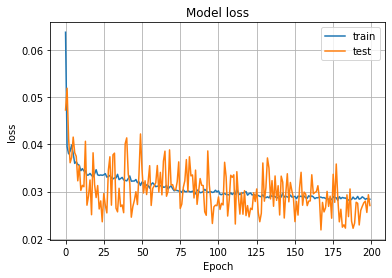

Test RMSE: 35.555
27.170893
0.06346098


TypeError: 'numpy.float32' object is not iterable

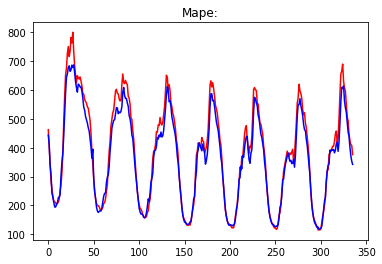

In [14]:
'''
{['n_neurons': 248, 'n_hidden': 3, 'learning_rate': 0.0001, 'score':-0.020301321148872377]
 ['n_neurons': 228, 'n_hidden': 3, 'learning_rate': 0.001, 'batch_size': 152,'score':-0.01886052545160055']
 'n_neurons': 101, 'n_hidden': 4, 'learning_rate': 0.001, -0.020518775284290313}
 'n_neurons': 249, 'n_hidden': 4, 'learning_rate': 0.0003} score: -0.019037528336048125
 {'n_neurons': 130, 'n_hidden': 5, 'learning_rate': 0.003}
score: -0.02070038244128227
'''
from math import sqrt
# split into train and test sets
values = reframed.values
n_train_hours = 536 * 48 - 7 * 48 - 1
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(130, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), activation="relu"))
model.add(LSTM(130,  return_sequences=True, activation="relu"))
model.add(LSTM(130, return_sequences=True, activation="relu"))
model.add(LSTM(130, return_sequences=True, activation="relu"))
model.add(LSTM(130, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss='mae', metrics=['mape'], optimizer=optimizer)
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=64, validation_split=0.1, verbose=2, shuffle=False)
# plot loss graph
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Model loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('loss')
pyplot.grid(True)
pyplot.legend()
pyplot.show()


# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print(mean_absolute_error(inv_y, inv_yhat))
print(mean_absolute_percentage_error(inv_y, inv_yhat))

# plot actual and preidict value
pyplot.plot(range(len(inv_y)), inv_y, c='r', label='actual value')
pyplot.plot(range(len(inv_yhat)), inv_yhat, c='b', label='prediction value')
pyplot.title('Mape:', mean_absolute_percentage_error(inv_y, inv_yhat))
pyplot.xlabel('Timepoint')
pyplot.ylabel('Power')
pyplot.grid(True)
pyplot.legend()
pyplot.show()

